In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [3]:
# Set plotting style
plt.style.use("seaborn-white")

RECORD_TO_TEXT = {
    "uci": "UCI Record",
    "best": "Best Human Effort",
    "unified": "Unified Record",
}

CURRENT_PALLETE = sns.color_palette()
PLOT_COLORS = {
    "uci": CURRENT_PALLETE[0],
    RECORD_TO_TEXT["uci"]: CURRENT_PALLETE[0],
    "best": CURRENT_PALLETE[1],
    RECORD_TO_TEXT["best"]: CURRENT_PALLETE[1],
    "unified": CURRENT_PALLETE[2],
    RECORD_TO_TEXT["unified"]: CURRENT_PALLETE[2],
}

WIDTH = 12
HEIGHT = 7

%matplotlib inline

# Load the data

I have already scraped the HTML, read it into Pandas, and cleaned it up. So I'll just load that cleaned data.

In [4]:
df = pd.read_json("./hour_record_dataframe.json", orient="table")

In [5]:
# Rename some riders who have *REALLY* long names
df = df.replace(
    {
        "Leontien Zijlaard-van Moorsel": "Leontien van Moorsel",
        "Molly Shaffer Van Houweling": "Molly Van Houweling",
    }
)

In [6]:
df.head()

,date,rider,age,velodrome,distance (km),equipment,success,gender,record
0,1972-10-25,Eddy Merckx,27.0,Agustín Melgar (333 meters outdoor concrete hi...,49.431,"Drop handlebar, round steel tubing frame, wire...",True,men,uci
1,1972-11-25,Maria Cressari,NaN,"Agustín Melgar Olympic Velodrome, Mexico City,...",41.471,"4.7-kilogram Colnago, drop handlebars, wire sp...",True,women,uci
2,1978-09-16,Keetie van Oosten,29.0,"Munich, Germany",43.082,"RIH superlight steel frame, drop handlebars, w...",True,women,uci
3,1984-01-19,Francesco Moser,32.0,Agustín Melgar (333 meters outdoor concrete hi...,50.808,"Bullhorn handlebar, oval steel tubing frame, d...",True,men,best
4,1984-01-23,Francesco Moser,32.0,Agustín Melgar (333 meters outdoor concrete hi...,51.151,"Bullhorn handlebar, oval steel tubing frame, d...",True,men,best


# Plotting

In [7]:
def draw_bands(ax, ticks=None):
    """Add grey bands to the plot.

    Args:
        ax: a matplotlib axes object.
        ticks: a list of tick postions, to use instead of the ones that come
            with ax.
    """
    if ticks is None:
        ticks = ax.get_xticks(minor=False)

    for i in range(0, len(ticks), 2):
        # Check for the end of the array
        if i >= len(ticks) or i + 1 >= len(ticks):
            return

        # Draw a band
        left_tick = ticks[i]
        right_tick = ticks[i + 1]
        plt.axvspan(left_tick, right_tick, color="0.97", zorder=-2)

    ticks = ax.get_xticks(minor=False)

In [8]:
def draw_legend(plt):
    """Draw the legend on the specified plot.

    Args:
        plt (matplotlib.pyplot): pyplot object
    """
    leg = plt.legend(
        loc="upper left",
        fontsize=18,
        ncol=1,
        frameon=1,
        fancybox=True,
        # The bellow commands remove the lines in the legend
        handlelength=0,
        handletextpad=0,
        markerscale=0,
    )

    # Turn on and theme the frame
    frame = leg.get_frame()
    frame.set_linewidth(1)
    frame.set_alpha(1)
    frame.set_facecolor("white")
    frame.set_edgecolor("black")

    # Set the legend text color to match the line color
    handles, _ = ax.get_legend_handles_labels()
    texts = leg.get_texts()
    for _, text in zip(handles, texts):
        text.set_color(PLOT_COLORS[text.get_text()])

    fig.tight_layout()

In [9]:
def annotate_point_with_name(row, color, nudges):
    rider = row["rider"]
    distance = row["distance (km)"]
    date = row["date"]
    text = f"{rider} ({distance} km)  "

    # Try to get nudges
    adjust = nudges.get((rider, distance), (0, 0))
    x_pos = date + pd.to_timedelta(adjust[0], unit="Y")
    y_pos = distance + adjust[1]

    plt.text(
        x_pos,
        y_pos,
        text,
        horizontalalignment="right",
        verticalalignment="center",
        color=color,
        fontsize=16,
        fontweight="bold",
    )

In [10]:
def plot_steps_and_markers(df, nudges, ax):
    MAX_DATE = max(df["date"])

    plt.sca(ax)

    for record in df["record"].unique():
        color = PLOT_COLORS[record]
        df_tmp = df[df["record"] == record]
        heights = list(df_tmp["distance (km)"].values)
        years = list(df_tmp["date"].values)
        # Exend to the end of the plot
        heights += [heights[-1]]
        years += [MAX_DATE]

        plt.step(
            x=years,
            y=heights,
            where="post",
            linewidth=2.5,
            color=color,
            label=RECORD_TO_TEXT[record],
        )
        plt.plot(years[:-1], heights[:-1], "o", color=color, markersize=10)

        for index, row in df_tmp.iterrows():
            annotate_point_with_name(row, color, nudges)

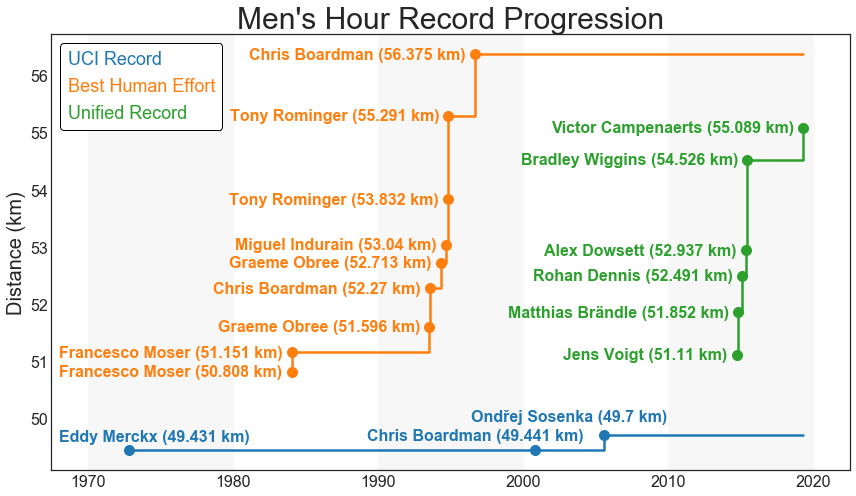

In [11]:
df_men = df[(df["gender"] == "men") & (df["success"] == True)]
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

annotation_nudge = {
    ("Eddy Merckx", 49.431): (9, 0.25),
    ("Chris Boardman", 49.441): (4, 0.25),
    ("Ondřej Sosenka", 49.7): (5, 0.33),
}

ax.set_ylabel("Distance (km)", fontsize=20)
plt.title("Men's Hour Record Progression", fontsize=30)

plot_steps_and_markers(df_men, annotation_nudge, ax)

ax.tick_params(axis="both", which="major", labelsize=16)

draw_bands(ax)
draw_legend(ax)

ticks = ax.get_xticks()

# Save to disk
for ext in ("png", "svg"):
    fig.savefig(
        "/tmp/mens_hour_records_progression.{ext}".format(ext=ext), bbox_inches="tight"
    )

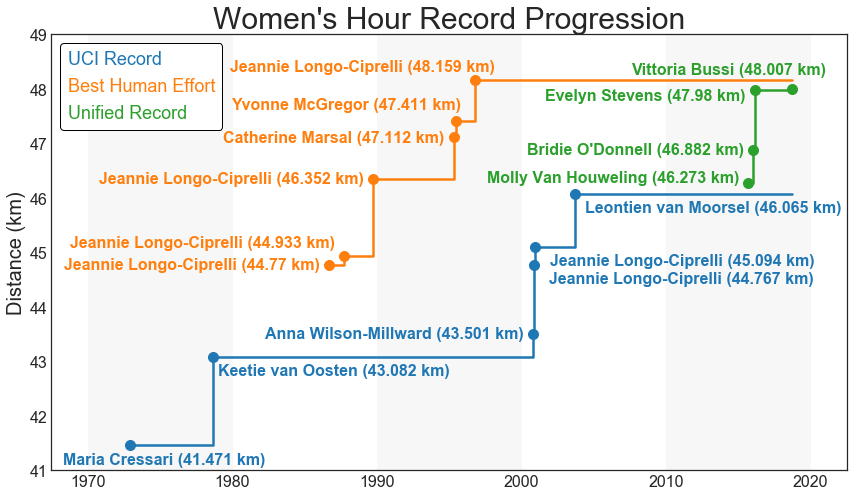

In [12]:
df_women = df[(df["gender"] == "women") & (df["success"] == True)]

fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

annotation_nudge = {
    ("Maria Cressari", 41.471): (10, -0.27),
    ("Keetie van Oosten", 43.082): (17, -0.25),
    ("Jeannie Longo-Ciprelli", 44.767): (20, -0.25),
    ("Jeannie Longo-Ciprelli", 45.094): (20, -0.25),
    ("Leontien van Moorsel", 46.065): (19, -0.25),
    ("Jeannie Longo-Ciprelli", 44.933): (0, 0.25),
    ("Yvonne McGregor", 47.411): (1, 0.3),
    ("Jeannie Longo-Ciprelli", 48.159): (2, 0.25),
    ("Molly Van Houweling", 46.273): (0, 0.1),
    ("Evelyn Stevens", 47.98): (0, -0.1),
    ("Vittoria Bussi", 48.007): (3, 0.35),
}

ax.set_ylabel("Distance (km)", fontsize=20)
plt.title("Women's Hour Record Progression", fontsize=30)

plot_steps_and_markers(df_women, annotation_nudge, ax)

ax.tick_params(axis="both", which="major", labelsize=16)

draw_bands(ax, ticks[1:-1])
draw_legend(ax)

ax.set_ylim(41, 49)
# ax.set_xlim(MIN_TIME, MAX_TIME)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig(
        "/tmp/womens_hour_records_progression.{ext}".format(ext=ext),
        bbox_inches="tight",
    )